## Cosine Similarity


In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


c:\Users\Jun Sheng\OneDrive\Desktop\SC4020-Project-1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "data/huggingface-2025-10-14.csv"
df = pd.read_csv(file_path)
df.head()

C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_14696\3769368811.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,score,sentence1,sentence2,score_binary
0,5.00,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,1.0
1,4.75,A young child is riding a horse.,A child is riding a horse.,1.0
2,5.00,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,1.0
3,2.40,A woman is playing the guitar.,A man is playing guitar.,0.0
4,2.75,A woman is playing the flute.,A man is playing a flute.,0.0


In [5]:
# Load a pre-trained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2') 

# Preprocess the dataframe to ensure sentences are strings
df['sentence1'] = df['sentence1'].apply(lambda x: str(x) if isinstance(x, str) else "")
df['sentence2'] = df['sentence2'].apply(lambda x: str(x) if isinstance(x, str) else "")

# List to store accuracy for each threshold
thresholds = []
accuracies = []

# Loop through thresholds from 0.5 to 0.9 with an increment of 0.05
for threshold in [i / 100 for i in range(50, 95, 5)]:

    # Test only the first 500 rows
    for index, row in df.head(500).iterrows():

        sentence1 = row['sentence1']
        sentence2 = row['sentence2']

        # Encode the sentences to get their embeddings
        sentence1_embedding = model.encode([sentence1])
        sentence2_embedding = model.encode([sentence2])

        # Compute cosine similarities
        similarity_score = cosine_similarity(sentence1_embedding, sentence2_embedding)

        # Populate the 'similarity' column based on the threshold
        if similarity_score[0][0] > threshold:
            df.at[index, 'similarity'] = 1
        else:
            df.at[index, 'similarity'] = 0

    # Only compute the confusion matrix using the first 500 rows (with similarity populated)
    cm = confusion_matrix(df.head(500)['score_binary'], df.head(500)['similarity'])

    # Extract values from confusion matrix
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)
    thresholds.append(threshold)


'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: a8ac255c-fee8-4910-9d65-776a56b44902)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


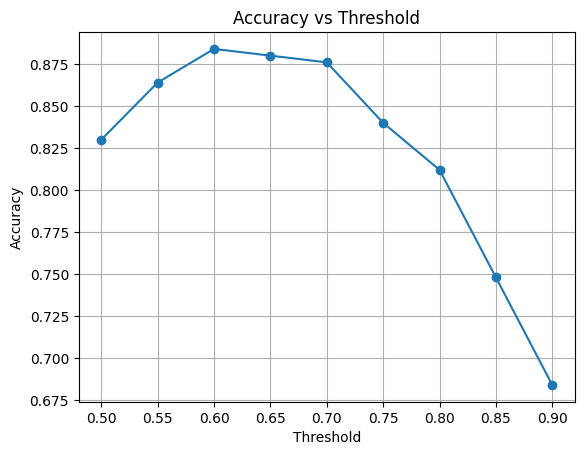

In [6]:
# Plotting the accuracy for different thresholds
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.grid(True)
plt.show()

### We can see from the plot that the cosine similarity threshold that yields the highest accuracy is 0.6. Hence we will set threshold = 0.6 and investigate the false positives and false negatives.

In [7]:
# Load a pre-trained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2') 

# Preprocess the dataframe to ensure sentences are strings
df['sentence1'] = df['sentence1'].apply(lambda x: str(x) if isinstance(x, str) else "")
df['sentence2'] = df['sentence2'].apply(lambda x: str(x) if isinstance(x, str) else "")

threshold = 0.6  

# Test only the first 500 rows
for index, row in df.head(500).iterrows():

    sentence1 = row['sentence1']
    sentence2 = row['sentence2']

    # Encode the sentences to get their embeddings
    sentence1_embedding = model.encode([sentence1])
    sentence2_embedding = model.encode([sentence2])

    # Compute cosine similarities
    similarity_score = cosine_similarity(sentence1_embedding, sentence2_embedding)

    # Populate the 'similarity' column based on the threshold
    if similarity_score[0][0] > threshold:
        df.at[index, 'similarity'] = 1
    else:
        df.at[index, 'similarity'] = 0

    # Only compute the confusion matrix using the first 500 rows (with similarity populated)
    cm = confusion_matrix(df.head(500)['score_binary'], df.head(500)['similarity'])

    # Extract values from confusion matrix
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)



In [8]:
# Filter rows where 'score_binary' and 'similarity' do not match
false_positives = df[(df['score_binary'] == 0) & (df['similarity'] == 1)]
false_negatives = df[(df['score_binary'] == 1) & (df['similarity'] == 0)]

# Combine both false positives and false negatives for investigation
false_cases = pd.concat([false_positives, false_negatives])


# Save the results to a CSV file
false_cases.to_csv("data/cosine_false_cases.csv", index=False)

# Confirm that the file is saved
print("False positives and negatives have been saved to 'data/cosine_false_cases.csv'.")

False positives and negatives have been saved to 'data/cosine_false_cases.csv'.


## Jaccard Similarity

In [9]:
# Preprocess the dataframe to ensure sentences are strings
df['sentence1'] = df['sentence1'].apply(lambda x: str(x) if isinstance(x, str) else "")
df['sentence2'] = df['sentence2'].apply(lambda x: str(x) if isinstance(x, str) else "")

# List to store accuracy for each threshold
thresholds = []
accuracies = []

# Function to compute Jaccard Similarity
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

# Loop through thresholds from 0.5 to 0.9 with an increment of 0.05
for threshold in [i / 100 for i in range(0, 95, 2)]:
    

    # Test only the first 500 rows
    for index, row in df.head(500).iterrows():

        sentence1 = row['sentence1']
        sentence2 = row['sentence2']

        # Convert sentences to sets of words
        set1 = set(sentence1.lower().split())
        set2 = set(sentence2.lower().split())

        # Compute Jaccard similarity
        similarity_score = jaccard_similarity(set1, set2)

        # Populate the 'similarity' column based on the threshold
        if similarity_score > threshold:
            df.at[index, 'similarity'] = 1
        else:
            df.at[index, 'similarity'] = 0

    # Only compute the confusion matrix using the first 500 rows (with similarity populated)
    cm = confusion_matrix(df.head(500)['score_binary'], df.head(500)['similarity'])

    # Extract values from confusion matrix
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)
    thresholds.append(threshold)

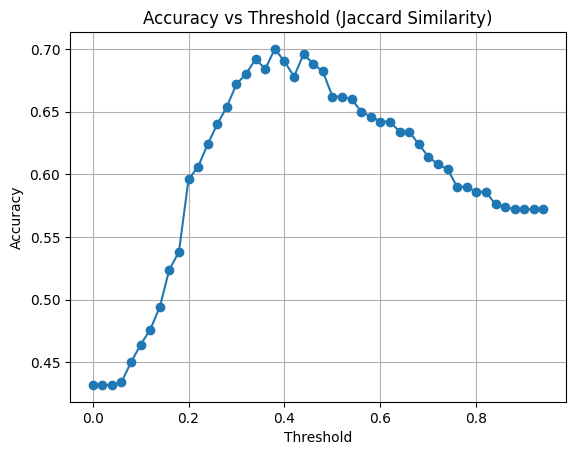

In [10]:
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold (Jaccard Similarity)')
plt.grid(True)
plt.show()


In [11]:
# Preprocess the dataframe to ensure sentences are strings
df['sentence1'] = df['sentence1'].apply(lambda x: str(x) if isinstance(x, str) else "")
df['sentence2'] = df['sentence2'].apply(lambda x: str(x) if isinstance(x, str) else "")

# Function to compute Jaccard Similarity
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

threshold = 0.38

# Test only the first 500 rows
for index, row in df.head(500).iterrows():

    sentence1 = row['sentence1']
    sentence2 = row['sentence2']

    # Convert sentences to sets of words
    set1 = set(sentence1.lower().split())
    set2 = set(sentence2.lower().split())

    # Compute Jaccard similarity
    similarity_score = jaccard_similarity(set1, set2)

    # Populate the 'similarity' column based on the threshold
    if similarity_score > threshold:
        df.at[index, 'similarity'] = 1
    else:
        df.at[index, 'similarity'] = 0

# Only compute the confusion matrix using the first 500 rows (with similarity populated)
cm = confusion_matrix(df.head(500)['score_binary'], df.head(500)['similarity'])

# Extract values from confusion matrix
TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"Accuracy at threshold {threshold} using Jaccard Similarity: {accuracy:.4f}")


Accuracy at threshold 0.38 using Jaccard Similarity: 0.7000


In [12]:
# Filter rows where 'score_binary' and 'similarity' do not match
false_positives = df[(df['score_binary'] == 0) & (df['similarity'] == 1)]
false_negatives = df[(df['score_binary'] == 1) & (df['similarity'] == 0)]

# Combine both false positives and false negatives for investigation
false_cases = pd.concat([false_positives, false_negatives])


# Save the results to a CSV file
false_cases.to_csv("data/jaccard_false_cases.csv", index=False)

# Confirm that the file is saved
print("False positives and negatives have been saved to 'data/jaccard_false_cases.csv'.")

False positives and negatives have been saved to 'data/jaccard_false_cases.csv'.


## Euclidean Distance

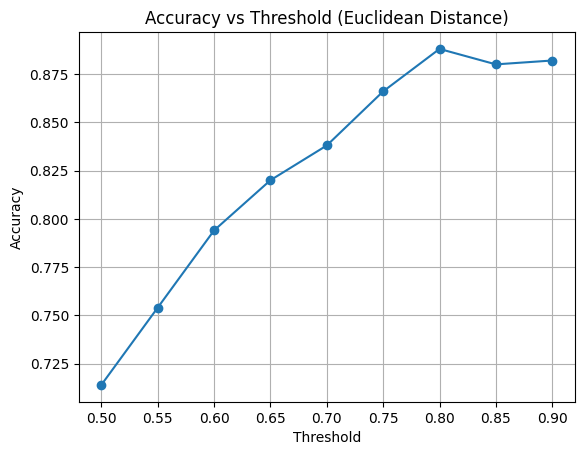

In [ ]:
# Load a pre-trained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2') 

# Preprocess the dataframe to ensure sentences are strings
df['sentence1'] = df['sentence1'].apply(lambda x: str(x) if isinstance(x, str) else "")
df['sentence2'] = df['sentence2'].apply(lambda x: str(x) if isinstance(x, str) else "")

# List to store accuracy for each threshold
thresholds = []
accuracies = []

# Function to compute Euclidean Distance
def euclidean_distance(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

# Loop through thresholds from 0.5 to 0.9 with an increment of 0.05
for threshold in [i / 100 for i in range(50, 95, 5)]:
    
    # Test only the first 500 rows
    for index, row in df.head(500).iterrows():

        sentence1 = row['sentence1']
        sentence2 = row['sentence2']

        # Generate embeddings for the sentences
        sentence1_embedding = model.encode([sentence1])
        sentence2_embedding = model.encode([sentence2])

        # Compute Euclidean distance between embeddings
        distance = euclidean_distance(sentence1_embedding, sentence2_embedding)

        # Populate the 'similarity' column based on the threshold (lower distance means more similar)
        if distance < threshold:
            df.at[index, 'similarity'] = 1
        else:
            df.at[index, 'similarity'] = 0

    # Only compute the confusion matrix using the first 500 rows (with similarity populated)
    cm = confusion_matrix(df.head(500)['score_binary'], df.head(500)['similarity'])

    # Extract values from confusion matrix
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)
    thresholds.append(threshold)

plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold (Euclidean Distance)')
plt.grid(True)
plt.show()


In [14]:
# Filter rows where 'score_binary' and 'similarity' do not match
false_positives = df[(df['score_binary'] == 0) & (df['similarity'] == 1)]
false_negatives = df[(df['score_binary'] == 1) & (df['similarity'] == 0)]

# Combine both false positives and false negatives for investigation
false_cases = pd.concat([false_positives, false_negatives])


# Save the results to a CSV file
false_cases.to_csv("data/euclidean_false_cases.csv", index=False)

# Confirm that the file is saved
print("False positives and negatives have been saved to 'data/euclidean_false_cases.csv'.")

False positives and negatives have been saved to 'data/euclidean_false_cases.csv'.
